In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
# Loading the Dataset
file_path = "./../CSV/merged_output_SIT_diff_classes.csv"     # Path to the dataset
data = pd.read_csv(file_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4987 entries, 0 to 4986
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       4987 non-null   int64 
 1   connection  4987 non-null   object
 2   timestamps  4987 non-null   object
 3   sizes       4987 non-null   object
 4   directions  4987 non-null   object
 5   file_name   4987 non-null   object
dtypes: int64(1), object(5)
memory usage: 233.9+ KB


In [4]:
data.shape                                              # num_flows, columns

(4987, 6)

### Column description
- index          : row idx
- connection     : 5-tuple describing the conn. (source IP, source port, destination IP, destination port, protocol).
- sizes          : A list of packet sizes (in bytes) for the connection.
- directions     : A list indicating packet directions (1 for outgoing, 0 for incoming).
- file_names     : The name of the PCAP file from which the data was extracted.
- timestamps     : A list of timestamps indicating when packets for the connection were captured.

In [5]:
data.columns

Index(['index', 'connection', 'timestamps', 'sizes', 'directions',
       'file_name'],
      dtype='object')

In [6]:
data.head()

,index,connection,timestamps,sizes,directions,file_name
0,1,"('10.184.62.19', 61599, '3.33.252.61', 443, 'T...","1727358570.247294,1727358570.321135,1727358570...","[66, 54, 307, 54, 54]","[0, 1, 0, 1, 0]",google_browsing.pcap
1,2,"('3.33.252.61', 443, '10.184.62.19', 61599, 'T...","1727358570.320960,1727358570.394823,1727358570...","[66, 54, 54]","[0, 0, 1]",google_browsing.pcap
2,3,"('10.184.62.19', 61532, '10.10.1.5', 53, 'UDP')",1727358570.998294,[75],[0],google_browsing.pcap
3,4,"('10.184.62.19', 51497, '10.10.1.5', 53, 'UDP')",1727358570.998542,[75],[0],google_browsing.pcap
4,5,"('10.10.1.5', 53, '10.184.62.19', 61532, 'UDP')",1727358571.000310,[91],[1],google_browsing.pcap


### Preprocessing: Creating additional Features

In [7]:
print(type(data["timestamps"]))
print(data["timestamps"][:5])
print(data["timestamps"][0])
print(len(data["timestamps"][0]))                       # currently an arr. of string
print(type(data["timestamps"][0]))                      # string  

<class 'pandas.core.series.Series'>
0    1727358570.247294,1727358570.321135,1727358570...
1    1727358570.320960,1727358570.394823,1727358570...
2                                    1727358570.998294
3                                    1727358570.998542
4                                    1727358571.000310
Name: timestamps, dtype: object
1727358570.247294,1727358570.321135,1727358570.322023,1727358570.394886,1727358570.394983
89
<class 'str'>


In [8]:
# Compute flow duration:
data["ts_split"] = data["timestamps"].apply(lambda x: list(map(float, x.split(','))))
data["flow_duration"] = data["ts_split"].apply(lambda x: max(x) - min(x) if isinstance(x, list) and len(x) > 1 else 0)
print(data["flow_duration"][:3])

0    0.147689
1    0.146736
2    0.000000
Name: flow_duration, dtype: float64


In [9]:
print(data["flow_duration"].value_counts())

flow_duration
0.000000     1412
3.020436        3
0.077764        3
0.020278        3
17.494159       2
             ... 
1.788063        1
1.782871        1
0.239742        1
0.482167        1
8.351740        1
Name: count, Length: 3556, dtype: int64


In [10]:
def get_float(str_array):
    ''' Convert a string of floats to a NumPy array of floats '''
    # Remove brackets and split the string by commas
    cleaned_string = str_array.strip("[]")              # Remove [ and ]
    string_list = cleaned_string.split(",")             # Split by commas

    # Convert to a NumPy array of floats
    float_array = np.array(string_list, dtype=float)
    return float_array 

for field in ["sizes", "directions"]:
    print(field)
    data[field] = data[field].apply(lambda x: get_float(x))

sizes
directions


In [11]:
data.head()

,index,connection,timestamps,sizes,directions,file_name,ts_split,flow_duration
0,1,"('10.184.62.19', 61599, '3.33.252.61', 443, 'T...","1727358570.247294,1727358570.321135,1727358570...","[66.0, 54.0, 307.0, 54.0, 54.0]","[0.0, 1.0, 0.0, 1.0, 0.0]",google_browsing.pcap,"[1727358570.247294, 1727358570.321135, 1727358...",0.147689
1,2,"('3.33.252.61', 443, '10.184.62.19', 61599, 'T...","1727358570.320960,1727358570.394823,1727358570...","[66.0, 54.0, 54.0]","[0.0, 0.0, 1.0]",google_browsing.pcap,"[1727358570.32096, 1727358570.394823, 17273585...",0.146736
2,3,"('10.184.62.19', 61532, '10.10.1.5', 53, 'UDP')",1727358570.998294,[75.0],[0.0],google_browsing.pcap,[1727358570.998294],0.000000
3,4,"('10.184.62.19', 51497, '10.10.1.5', 53, 'UDP')",1727358570.998542,[75.0],[0.0],google_browsing.pcap,[1727358570.998542],0.000000
4,5,"('10.10.1.5', 53, '10.184.62.19', 61532, 'UDP')",1727358571.000310,[91.0],[1.0],google_browsing.pcap,[1727358571.00031],0.000000


In [12]:
data.drop(columns=["timestamps"], inplace=True)
data.rename(columns={"ts_split": "timestamps"}, inplace=True)

In [13]:
data.tail(5)

,index,connection,sizes,directions,file_name,timestamps,flow_duration
4982,4983,"('10.10.1.5', 53, '10.184.62.19', 55689, 'UDP')",[79.0],[1.0],teams_messaging.pcap,[1727359066.796789],0.000000
4983,4984,"('10.184.62.19', 64259, '20.190.175.152', 443,...","[66.0, 54.0, 590.0, 590.0, 590.0, 239.0, 590.0...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",teams_messaging.pcap,"[1727359066.797213, 1727359066.827417, 1727359...",0.289631
4984,4985,"('20.190.175.152', 443, '10.184.62.19', 64259,...","[66.0, 54.0, 54.0, 153.0, 54.0, 590.0, 590.0, ...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",teams_messaging.pcap,"[1727359066.827288, 1727359066.857509, 1727359...",0.259448
4985,4986,"('10.184.62.19', 55454, '10.10.1.5', 53, 'UDP')",[91.0],[0.0],teams_messaging.pcap,[1727359072.21143],0.000000
4986,4987,"('10.10.1.5', 53, '10.184.62.19', 55454, 'UDP')",[91.0],[1.0],teams_messaging.pcap,[1727359072.243714],0.000000


In [14]:
label_col = "label"
data[label_col] = data["file_name"].apply(lambda x: x.replace(".pcap", ""))                 # Extract label from the filename

In [15]:
print(data[label_col].value_counts())

label
google_browsing           2631
google_drive_upl-dw        530
streaming_spotify          466
google_mail                454
teams_messaging            380
teams_call                 276
streaming_amazon-prime     122
streaming_hotstar           47
streaming_netflix           46
streaming_youtube           35
Name: count, dtype: int64


In [16]:
# Dropping Classes with Less than 20 Instances
class_counts = data[label_col].value_counts()                                               # generate series of class_count
data = data[data[label_col].isin(class_counts[class_counts > 20].index)]

le = LabelEncoder()
data["label_encoded"] = le.fit_transform(data["label"])

In [17]:
# Hot encoding for labels
print(dict(zip(le.classes_, range(len(le.classes_)))))

{'google_browsing': 0, 'google_drive_upl-dw': 1, 'google_mail': 2, 'streaming_amazon-prime': 3, 'streaming_hotstar': 4, 'streaming_netflix': 5, 'streaming_spotify': 6, 'streaming_youtube': 7, 'teams_call': 8, 'teams_messaging': 9}


In [18]:
# Remove the file_name column (no more reqd.)
data = data.drop(columns=["file_name"])

In [19]:
print(data["sizes"].head(5))

# Check the data type of each entry in the 'sizes' column
print(data["sizes"].apply(type).value_counts())

direction_example = data.loc[1, "directions"]
print(direction_example)

print(len(direction_example))

0    [66.0, 54.0, 307.0, 54.0, 54.0]
1                 [66.0, 54.0, 54.0]
2                             [75.0]
3                             [75.0]
4                             [91.0]
Name: sizes, dtype: object
sizes
<class 'numpy.ndarray'>    4987
Name: count, dtype: int64
[0. 0. 1.]
3


In [20]:
def get_IAT(timestamps):
    """Compute Inter-Arrival Time (IAT) for a list of timestamps."""
    if len(timestamps) > 1:
        return np.diff(timestamps)      # Compute differences between consecutive timestamps
    return np.array([])                 # Return empty array if there's only one packet

In [21]:
def compute_flow_features(df):
    flow_features = []
    
    for index, row in df.iterrows():
        ts_list = row['timestamps']
        flow_duration = row['flow_duration']
        size_list = row['sizes']
        dir_list = row['directions']

        # Separate Fwd and Bwd packets
        fwd_sizes = [size for size, direction in zip(size_list, dir_list) if direction == 1]
        bwd_sizes = [size for size, direction in zip(size_list, dir_list) if direction == 0]

        fwd_timestamps = [ts for ts, direction in zip(ts_list, dir_list) if direction == 1]
        bwd_timestamps = [ts for ts, direction in zip(ts_list, dir_list) if direction == 0]

        # Compute IATs
        flow_iat = get_IAT(ts_list)
        fwd_iat = get_IAT(fwd_timestamps)
        bwd_iat = get_IAT(bwd_timestamps)

        # Compute Flow Features
        flow_data = {
            'Avg. Packet Size': np.mean(size_list) if len(size_list) > 0 else 0,
            'Std Packet Size': np.std(size_list) if len(size_list) > 1 else 0,
            'Max Packet Size': max(size_list) if len(size_list) > 0 else 0,
            'Min Packet Size': min(size_list) if len(size_list) > 0 else 0,
            'Total Bytes': sum(size_list),
            'Total Packets': len(size_list),
            'Total Fwd Packets': len(fwd_sizes),
            'Total Backward Packets': len(bwd_sizes),
            'Total Length of Fwd Packets': sum(fwd_sizes) if fwd_sizes else 0,
            'Total Length of Bwd Packets': sum(bwd_sizes) if bwd_sizes else 0,
            'Fwd Packet Length Max': max(fwd_sizes) if fwd_sizes else 0,
            'Fwd Packet Length Min': min(fwd_sizes) if fwd_sizes else 0,
            'Fwd Packet Length Mean': np.mean(fwd_sizes) if fwd_sizes else 0,
            'Fwd Packet Length Std': np.std(fwd_sizes) if len(fwd_sizes) > 1 else 0,
            'Bwd Packet Length Max': max(bwd_sizes) if bwd_sizes else 0,
            'Bwd Packet Length Min': min(bwd_sizes) if bwd_sizes else 0,
            'Bwd Packet Length Mean': np.mean(bwd_sizes) if bwd_sizes else 0,
            'Bwd Packet Length Std': np.std(bwd_sizes) if len(bwd_sizes) > 1 else 0,
            'Flow Bytes/s': (sum(fwd_sizes) + sum(bwd_sizes)) / flow_duration if flow_duration > 0 else 0,
            'Flow Packets/s': (len(fwd_sizes) + len(bwd_sizes)) / flow_duration if flow_duration > 0 else 0,
            'Flow IAT Mean': np.mean(flow_iat) if len(flow_iat) > 0 else 0,
            'Flow IAT Std': np.std(flow_iat) if len(flow_iat) > 1 else 0,
            'Flow IAT Max': np.max(flow_iat) if len(flow_iat) > 0 else 0,
            'Flow IAT Min': np.min(flow_iat) if len(flow_iat) > 0 else 0,
            'Fwd IAT Total': np.sum(fwd_iat) if len(fwd_iat) > 0 else 0,
            'Fwd IAT Mean': np.mean(fwd_iat) if len(fwd_iat) > 0 else 0,
            'Fwd IAT Std': np.std(fwd_iat) if len(fwd_iat) > 1 else 0,
            'Fwd IAT Max': np.max(fwd_iat) if len(fwd_iat) > 0 else 0,
            'Fwd IAT Min': np.min(fwd_iat) if len(fwd_iat) > 0 else 0,
            'Bwd IAT Total': np.sum(bwd_iat) if len(bwd_iat) > 0 else 0,
            'Bwd IAT Mean': np.mean(bwd_iat) if len(bwd_iat) > 0 else 0,
            'Bwd IAT Std': np.std(bwd_iat) if len(bwd_iat) > 1 else 0,
            'Bwd IAT Max': np.max(bwd_iat) if len(bwd_iat) > 0 else 0,
            'Bwd IAT Min': np.min(bwd_iat) if len(bwd_iat) > 0 else 0,
        }

        flow_features.append(flow_data)

    return pd.DataFrame(flow_features)

In [22]:
# Compute features for the dataset
df_features = compute_flow_features(data)
data = pd.concat([data, df_features], axis=1)           # Merge with original dataset

print(data.shape)
print(data.head())

(4987, 42)
   index                                         connection  \
0      1  ('10.184.62.19', 61599, '3.33.252.61', 443, 'T...   
1      2  ('3.33.252.61', 443, '10.184.62.19', 61599, 'T...   
2      3    ('10.184.62.19', 61532, '10.10.1.5', 53, 'UDP')   
3      4    ('10.184.62.19', 51497, '10.10.1.5', 53, 'UDP')   
4      5    ('10.10.1.5', 53, '10.184.62.19', 61532, 'UDP')   

                             sizes                 directions  \
0  [66.0, 54.0, 307.0, 54.0, 54.0]  [0.0, 1.0, 0.0, 1.0, 0.0]   
1               [66.0, 54.0, 54.0]            [0.0, 0.0, 1.0]   
2                           [75.0]                      [0.0]   
3                           [75.0]                      [0.0]   
4                           [91.0]                      [1.0]   

                                          timestamps  flow_duration  \
0  [1727358570.247294, 1727358570.321135, 1727358...       0.147689   
1  [1727358570.32096, 1727358570.394823, 17273585...       0.146736   
2     

In [23]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
index,4987.0,2494.000000,1439.767227,1.0,1247.5,2494.000000,3740.500000,4.987000e+03
flow_duration,4987.0,15.886249,30.849675,0.0,0.0,2.653276,18.958134,2.285162e+02
label_encoded,4987.0,2.183878,3.118735,0.0,0.0,0.000000,4.000000,9.000000e+00
Avg. Packet Size,4987.0,271.384307,223.207364,54.0,100.0,228.555556,341.186712,1.292000e+03
Std Packet Size,4987.0,160.513063,139.665913,0.0,0.0,204.909371,241.200715,6.028210e+02
Max Packet Size,4987.0,499.386605,332.092490,54.0,119.0,590.000000,590.000000,1.292000e+03
Min Packet Size,4987.0,101.848205,191.409042,54.0,54.0,54.000000,77.000000,1.292000e+03
Total Bytes,4987.0,49429.853619,715890.343434,54.0,161.5,4185.000000,8458.000000,3.583119e+07
Total Packets,4987.0,98.054542,1220.062389,1.0,1.0,16.000000,28.000000,6.082800e+04
Total Fwd Packets,4987.0,81.476840,1162.930593,0.0,1.0,9.000000,17.000000,5.935200e+04


In [24]:
feature_cols = list(df_features.columns) + ["flow_duration"]                 # Feature selection

# Drop values with no data
data_tmp = data.copy()

# Select only numeric columns & drop NaN values from them
numeric_cols = data_tmp.select_dtypes(include=[np.number]).columns
data_tmp[numeric_cols] = data_tmp[numeric_cols].replace([np.inf, -np.inf], np.nan)
data_tmp.dropna(inplace=True)

features = data_tmp[feature_cols]
labels = data_tmp["label_encoded"]

print(data_tmp.shape)               # Total Data size after dropping NaN values
print(features.shape)               # Feature size after dropping NaN values

(4987, 42)
(4987, 35)


In [25]:
print(len(data_tmp.columns))                    # 7 columns from original dataset + 35 columns from feature extraction
data_tmp.columns

42


Index(['index', 'connection', 'sizes', 'directions', 'timestamps',
       'flow_duration', 'label', 'label_encoded', 'Avg. Packet Size',
       'Std Packet Size', 'Max Packet Size', 'Min Packet Size', 'Total Bytes',
       'Total Packets', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min'],
      dtype='object')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
print("Overall data shape : ", data_tmp.shape)                       # Total data size after dropping NaN values
print("Feature vector     : ", features.shape)                       # Feature size after dropping NaN values

print("X_train shape      : ", X_train.shape)                        # Feature matrix for training data          2503 samples, with 6 features each                  0.3 test size
print("y_train shape      : ", y_train.shape)                        # Target vector for training data

print("X_test shape       : ", X_test.shape)                         # Feature matrix for testing data           1073 samples
print("y_test shape       : ", y_test.shape)                         # Actual labels for test data

Overall data shape :  (4987, 42)
Feature vector     :  (4987, 35)
X_train shape      :  (3490, 35)
y_train shape      :  (3490,)
X_test shape       :  (1497, 35)
y_test shape       :  (1497,)


***
# Simple Random Forest - 64%

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [35]:
# Simple Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_simple = rf.predict(X_test)
print(classification_report(y_test, y_pred_simple, target_names=le.classes_))

                        precision    recall  f1-score   support

       google_browsing       0.75      0.87      0.81       808
   google_drive_upl-dw       0.42      0.34      0.37       146
           google_mail       0.37      0.25      0.30       126
streaming_amazon-prime       0.80      0.76      0.78        42
     streaming_hotstar       0.31      0.38      0.34        13
     streaming_netflix       1.00      0.15      0.27        13
     streaming_spotify       0.47      0.51      0.49       145
     streaming_youtube       0.40      0.22      0.29         9
            teams_call       0.36      0.26      0.30        76
       teams_messaging       0.44      0.31      0.36       119

              accuracy                           0.64      1497
             macro avg       0.53      0.41      0.43      1497
          weighted avg       0.61      0.64      0.62      1497



***
# RF with Grid Search - 61%

In [36]:
param_grid = {
    'n_estimators': [100, 300, 500],                                # Number of trees in the forest
    'max_depth': [10, 20, 30, None],                                # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                                # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                                  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],                               # Number of features to consider when looking for the best split
    'bootstrap': [True, False]
}

# Initalizing the Random Forest Classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Performing Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)
print()

# Classification report
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

                        precision    recall  f1-score   support

       google_browsing       0.83      0.80      0.81       808
   google_drive_upl-dw       0.32      0.32      0.32       146
           google_mail       0.29      0.33      0.31       126
streaming_amazon-prime       0.70      0.79      0.74        42
     streaming_hotstar       0.33      0.46      0.39        13
     streaming_netflix       0.36      0.38      0.37        13
     streaming_spotify       0.48      0.48      0.48       145
     streaming_youtube       0.33      0.22      0.27         9
            teams_call       0.32      0.38      0.35        76
       teams_messaging       0.34      0.30      0.32       119

              accuracy                           0.61      1497
             macro avg       0.43      0.45      0.43      1497
          weighted 

In [37]:
print("y_pred shape       : ", y_pred.shape)                         # Predicted labels for test data
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

y_pred shape       :  (1497,)

Accuracy: 0.61


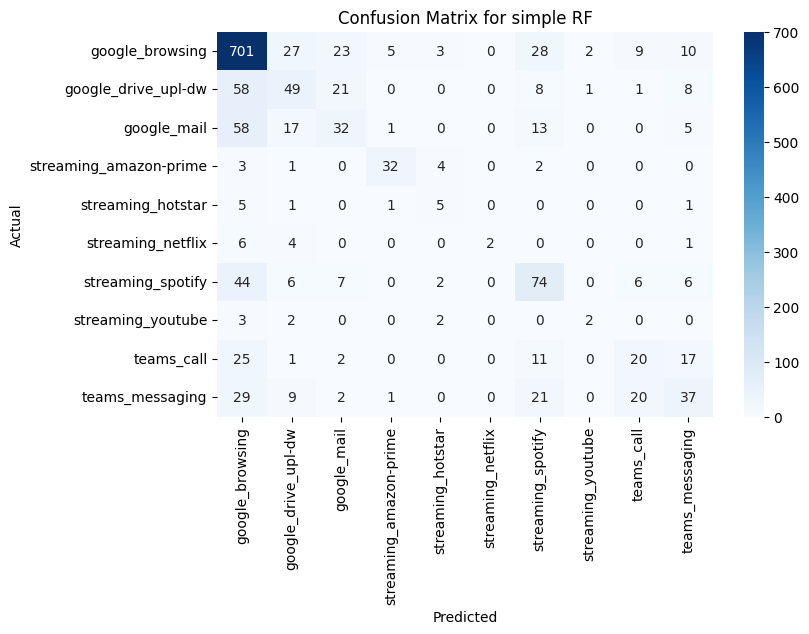

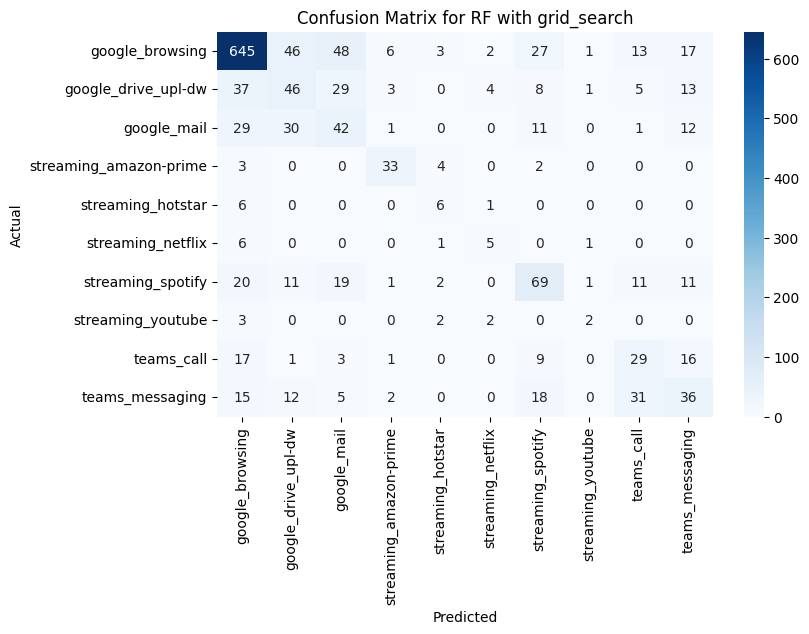

In [38]:
# Confusion Matrix plot for RF & RF=Grid Search
for y_pred in [y_pred_simple, y_pred]:
    model = "simple RF" if y_pred is y_pred_simple else "RF with grid_search"
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix for {model}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

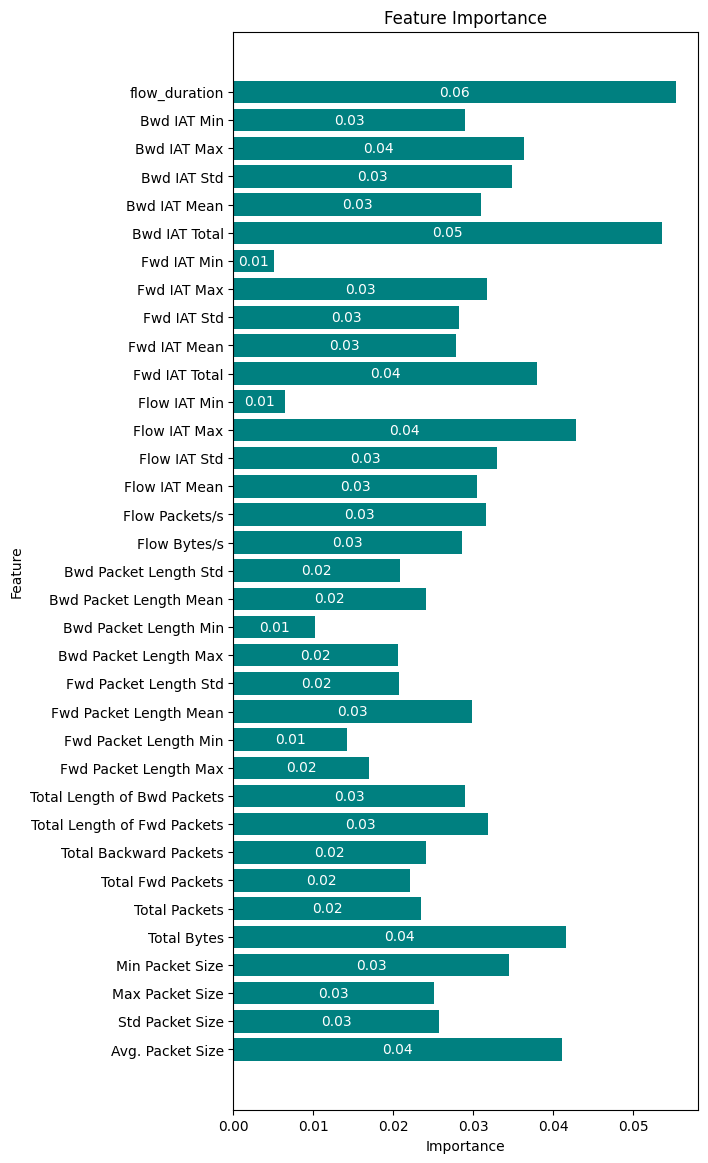

In [39]:
# Plot for Feature Importance
# importances = rf.feature_importances_
importances = best_model.feature_importances_
feature_names = features.columns

plt.figure(figsize=(6, 14))
bars = plt.barh(feature_names, importances, color='teal')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
for bar in bars:
    plt.text(bar.get_width() / 2,                               # X position (center of the bar)
             bar.get_y() + bar.get_height() / 2,                # Y position (center)
             f'{bar.get_width():.2f}',                          # Display importance value
             ha='center', va='center', fontsize=10, color='white')  
    
plt.show()

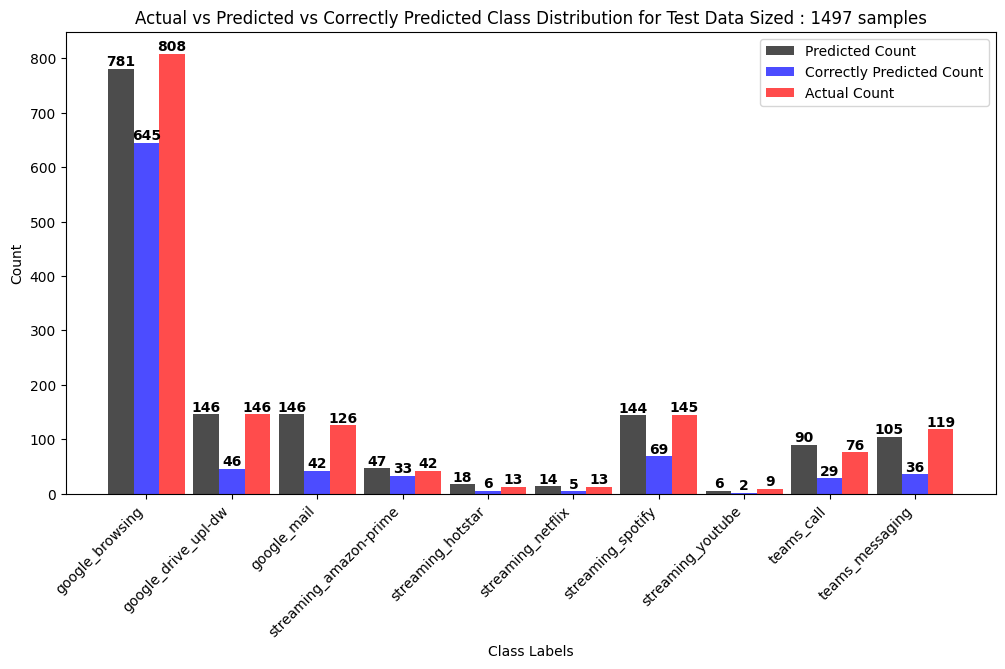

In [40]:
# Mapping encoded labels to class names
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))

# Invert dictionary to get {0: 'google_browsing', 1: 'google_drive_upl-dw', ...}
label_mapping_inv = {v: k for k, v in label_mapping.items()}

# class distribution
unique_actual, counts_actual = np.unique(y_test, return_counts=True)    # Actual class distribution
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)        # Predicted class distribution

# Convert numbers to class labels
actual_labels = [label_mapping_inv[i] for i in unique_actual]
predicted_labels = [label_mapping_inv[i] for i in unique_pred]

# Ensure all labels are present (even if missing in predictions)
all_labels = sorted(set(actual_labels) | set(predicted_labels), key=lambda x: label_mapping[x])

# Convert to dictionary for alignment
actual_counts_dict = dict(zip(actual_labels, counts_actual))
predicted_counts_dict = dict(zip(predicted_labels, counts_pred))

# Fill missing classes with zero count
actual_counts = [actual_counts_dict.get(label, 0) for label in all_labels]
predicted_counts = [predicted_counts_dict.get(label, 0) for label in all_labels]

# Count correctly predicted samples for each class (True Positives)
true_positives = {label: 0 for label in all_labels}  # Initialize all as 0

for actual, pred in zip(y_test, y_pred):
    if actual == pred:  # Correct prediction
        class_label = label_mapping_inv[actual]
        true_positives[class_label] += 1

# Convert true positives to a list for plotting
true_positive_counts = [true_positives.get(label, 0) for label in all_labels]

# Bar width and positions
x = np.arange(len(all_labels))  # Positions for bars
width = 0.3  # Width of bars

# Plot
plt.figure(figsize=(12,6))
bars1 = plt.bar(x - width, predicted_counts, width, label="Predicted Count", color="black", alpha=0.7)
bars2 = plt.bar(x, true_positive_counts, width, label="Correctly Predicted Count", color="blue", alpha=0.7)
bars3 = plt.bar(x + width, actual_counts, width, label="Actual Count", color="red", alpha=0.7)

# Add text labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and Title
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title(f'Actual vs Predicted vs Correctly Predicted Class Distribution for Test Data Sized : {len(y_test)} samples')
plt.xticks(ticks=x, labels=all_labels, rotation=45, ha='right')  # Rotate x-labels for better readability
plt.legend()
plt.show()

***
# RandomizedSearchCV - 63%

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Controls the number of random combinations
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Uses all available cores
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

***
# XGBoost - 64%

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=30,
    learning_rate=0.05,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

***
# Stratified K-fold - 61%

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='accuracy')

print(f"Stratified K-Fold Accuracy: {scores.mean():.2f}")

***
# LightGBM - 65%

In [ ]:
!pip3 install lightgbm

In [30]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_class=len(set(y_train)), random_state=42)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))                                  # Baseline model accuracy
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7343
[LightGBM] [Info] Number of data points in the train set: 3490, number of used features: 35
[LightGBM] [Info] Start training from score -0.649418
[LightGBM] [Info] Start training from score -2.207014
[LightGBM] [Info] Start training from score -2.364643
[LightGBM] [Info] Start training from score -3.775630
[LightGBM] [Info] Start training from score -4.631296
[LightGBM] [Info] Start training from score -4.661149
[LightGBM] [Info] Start training from score -2.386216
[LightGBM] [Info] Start training from score -4.899560
[LightGBM] [Info] Start training from score -2.859340
[LightGBM] [Info] Start training from score -2.593137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [ ]:
lgbm_balanced = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_class=len(set(y_train)),
                                   class_weight='balanced', random_state=42)

lgbm_balanced.fit(X_train, y_train)
y_pred_balanced = lgbm_balanced.predict(X_test)

print("Balanced Accuracy:", accuracy_score(y_test, y_pred_balanced))                    # Balanced classes accuracy
print(classification_report(y_test, y_pred_balanced))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7343
[LightGBM] [Info] Number of data points in the train set: 3490, number of used features: 35
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [33]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [10, 20, 30],
    'num_leaves': [20, 50, 100],
    'min_child_samples': [10, 20, 50]
}

lgbm_grid = GridSearchCV(lgb.LGBMClassifier(objective='multiclass', class_weight='balanced', random_state=42),
                         param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

lgbm_grid.fit(X_train, y_train)

print("Best Parameters:", lgbm_grid.best_params_)
best_lgbm = lgbm_grid.best_estimator_

y_pred_best = best_lgbm.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))                 # Tuned model accuracy
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7343
[LightGBM] [Info] Number of data points in the train set: 3490, number of used features: 35
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N